In [38]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
from pytorch_lightning import loggers as pl_loggers
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import torchmetrics

# Pytorch-Lightning : Training made Easier

Time : 4 hours

In the Tutorial session, we used PyTorch to train different models for Binary Classification. In the tutorial, few things were done :


*   We created a Training/Testing Loop and trained our models
*   We created a Trainer Class to gather all loops to perform the Training/Testing.


As you have seen, writing the training and testing loop can quickly be indigest. One can get easily lost.

Let us introduce you Pytorch Lightning

<img src="https://warehouse-camo.ingress.cmh1.psfhosted.org/a88de56e65d2ea6bc203ce178a1cecbe9b50a0ac/68747470733a2f2f6769746875622e636f6d2f5079546f7263684c696768746e696e672f7079746f7263682d6c696768746e696e672f7261772f312e342e392f646f63732f736f757263652f5f7374617469632f696d616765732f6c6f676f2e706e67">


Pytorch lightning will handle a lot of things for you. It creates a Trainer which is a Code Management trick used by many companies (Meta, Google..) in order to get much more digest code.


More Information on : https://www.pytorchlightning.ai/

Goal of this lab :

* Use Pytorch Lightning for Training
* Learn to use Pytorch-Lightning
* Do classification on MNIST, CIFAR-10


# I - Classify Numbers using Lightning

In this part, we are interested in classifying digit images ranging from 0 to 9. 
We will use the Lightning framework for code management. What's interesting about Lightning is that you can plug in your Torch modules without any modification.

## a - LightningDataModule : MNIST

As you have seen in the Tutorial, you need to create your Dataset Class.

As a reminder :    
 The Dataset class returns one sample of your dataset at a time. The main methods of the Dataset class are 

*   __getitem__ : which fetched a sample at a given index
*   __len__ : which returns the len of the total dataset

The Dataset is loaded into a DataLoader. That Dataloader is then used to **fetch and send data as batches** for your Model.

You will see that using Lightning makes things clearer. LightningDataModule allows you to write cleaner Code and fit easily your data to your model.

You can always, use the basic Pytorch Dataloader in a separate code.

We are first going to work with the MNIST dataset. There is already a MNIST class provided in the Torchvision library, so we don't have to code the Dataset implementation ourself.
* Fill in the blanks

### Exploratory Data Analysis : Discovering the Data

Before tackling the classification task it is essential to explore the data we are working on, and understand its specifics.
Perform an Exploratory Data Analysis (EDA) on the MNIST Dataset :

1.   What type of Data do you have ? (Images, Texts, Sound..)
2.   How many Data do you have ? 
3.   What's in a sample (1 element of the Dataset)
4.   Is the Dataset umbalanced ?
5.   What's the shape of any input sample ?
6.   ....




In [39]:
# Loading the Training Split of MNIST Dataset
dataset_train  = MNIST('', train=True, download=True)
dataset_test = MNIST('', train=False, download=True)

In [40]:
# TODO : What's the length of the train and test split ?

print("the length if the test dataset is :",len(dataset_test))
print("the length of the train dataset is :",len(dataset_train))

the length if the test dataset is : 10000
the length of the train dataset is : 60000


In [41]:
# TODO : Retrieve one sample of the Dataset.
sample, label = dataset_train[0]

# TODO : What is in a sample ? Print the sample to understand
print(f"Sample shape: {sample}, Label: {label}")

Sample shape: <PIL.Image.Image image mode=L size=28x28 at 0x31818E400>, Label: 5


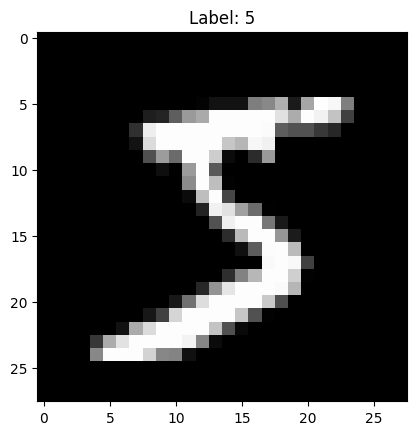

In [42]:
# TODO : Plot the image in the sample. Does it correspond to the second element of the sample ?

plt.imshow(sample, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

In [43]:
# TODO : What's the shape of the input image.
shape = sample.size

print(f"The shape of the sample is :{shape}")

The shape of the sample is :(28, 28)


### Lightning DataModule : Dataset and DataLoader Embedded 

Pytorch Lightning introduces a new way to define and organize our dataset via "data module". They neatly encompass our training, validation and testing datasets and provide their dataloaders as well.

Have a look at : https://pytorch.org/vision/stable/datasets.html

We are now going to define a `LightningDataModule` for the MNIST dataset. 

In [44]:
class MNISTDataModule(pl.LightningDataModule):

    def __init__(self):
        super().__init__()
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        self.data_dir = ''
        self.batch_size_train, self.batch_size_valid, self.batch_size_test = 32,32,32

    def prepare_data(self):
        # This method is used to download beforehand the dataset if needed.
        # TODO : Load the train and test dataset.
        dataset_train = MNIST(self.data_dir, train=True, download=True)
        dataset_test = MNIST(self.data_dir, train=False, download=True)
        

    def setup(self, stage):
        # We need to setup our module. We have 
        #  1. A training set that we will **fit** our model to
        #  2. A testing set used to **test** our models prediction.
        
        # The stage variable corresponds to those two steps : 
        # stage in {fit, test, None}

        # First stage is 'fit' (or None)
        if stage == "fit" or stage is None:
            # We create a validation split to watch the training.

            # Which dataset do we load for training ?
            mnist_dataset = MNIST(self.data_dir, train=True, transform=self.transform)
            train_size = int(0.8 * len(mnist_dataset))
            valid_size = len(mnist_dataset) - train_size
            mnist_train, mnist_valid =  torch.utils.data.random_split(mnist_dataset, [train_size, valid_size]) #random split into valid and train set
            
            # Load the datasets as attributes of the Module. Don't forget you validation split
            self.mnist_train, self.mnist_valid = mnist_train, mnist_valid

        # Second stage is 'test' 
        if stage == "test" or stage is None:

            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)
            # Question : What additional set can we create ? Why ?
            # We can do the same and split the test set into validation and test
            # It is not a usual application
            # It can be done for hyperparameters application

    def train_dataloader(self):
        # TODO : Now create your Training DataLoader
        return torch.utils.data.DataLoader(self.mnist_train, batch_size=self.batch_size_train, shuffle=True)


    def val_dataloader(self):
        # TODO : Now create your Validation DataLoader
        return torch.utils.data.DataLoader(self.mnist_valid, batch_size=self.batch_size_valid)

    def test_dataloader(self):
        # TODO : Now create your Testing DataLoader
        return torch.utils.data.DataLoader(self.mnist_test, batch_size=self.batch_size_test)



## b - LightningModule :  MNIST Classifier 

Similarly to `LightningDataModule`, pytorch Lightning provides a `LightningModule` that gathers every functions needed for the training and testing of our pytorch model.
 
Design a model to perform Classification using the `LightningModule` class layout. Again, ask yourself the following questions: 
* What task is it ?
* What data do I have ?
* What learning rate should I use ?
* What could be my loss ? Why ?
* What non-linearity should I use ?
* How do I evaluate my model ? (TorchMetrics is your friend)

In [52]:
class MNISTClassifier(pl.LightningModule):
    def __init__(self, output_shape, learning_rate=1e-3):
        super(MNISTClassifier,self).__init__()
        # what is the output_shape of your model ?
        self.output_shape = output_shape
        self.save_hyperparameters()
        self.learning_rate = learning_rate  # Save the learning rate as an instance attribute

        # TODO : Define your model here, be careful, your model will be an instance of the class. Watch  out for the input data.
        
        # Ddefine the model (réseau de neurones simple pour MNIST)
        self.model = nn.Sequential(
            nn.Flatten(), #Flatten images 28x28 into a vector of 784
            nn.Linear(28 * 28, 128),  # First fully connected layer
            nn.ReLU(),  # Non-linear activation
            nn.Linear(128, 64),  # Second fully connected layer
            nn.ReLU(),  # Non-linear activation
            nn.Linear(64, self.output_shape)  # Final layer for the 10 classe output
        )

        # Accuracy using torchmetrics
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=self.output_shape)
        
        self.train_acc = self.accuracy
        self.val_acc = self.accuracy
        self.test_acc = self.accuracy
        
        
    def forward(self,x):
        # TODO : What would be the forward steps of this classifier ? Return the output of our classifier given an input batch x.
        return self.model(x)

    def configure_optimizers(self):
        # TODO : Choose your optimizer : https://pytorch.org/docs/stable/optim.html
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        # TODO : Define your Training Step
        # Extract data from the batch (x = images, y = labels)
        x, y = batch
    
        # Pass the images through the model
        logits = self(x)  # The model returns raw logits (unnormalized outputs)
    
        # Compute the loss using CrossEntropyLoss (suitable for multi-class classification)
        loss = nn.CrossEntropyLoss()(logits, y)
    
        # Calculate accuracy using the TorchMetrics Accuracy method defined in __init__
        acc = self.train(logits.softmax(-1), y)
    
        # Log the training accuracy (on_epoch=True means we log it after the full epoch, not after each batch)
        self.log('train_acc', acc, on_step=False, on_epoch=True)  # Log training accuracy
    
        # Log the training loss (logged for every batch)
        self.log('train_loss', loss)
    
        # Return the loss, which will be used for backpropagation
        return loss

    def validation_step(self, batch, batch_idx):
        # TODO : Define your Validation Step
        # What is the difference between the Training and the Validation Step ?
        # there is no backpropagation on this step, the only aim is to measure the performance of the model, no weights update
        
        # Extract data from the batch (x = images, y = labels)
        x, y = batch
    
        # Pass the images through the model (forward pass)
        logits = self(x)  # The model returns raw logits (unnormalized outputs)
    
        # Compute the loss using CrossEntropyLoss (suitable for multi-class classification)
        loss = nn.CrossEntropyLoss()(logits, y)
    
        # Calculate accuracy using TorchMetrics Accuracy method defined in __init__
        acc = self.val_acc(logits.softmax(-1), y)
    
        # Log the validation accuracy and loss
        self.log('val_acc', acc, on_step=False, on_epoch=True)  # Log validation accuracy
        self.log('val_loss', loss)  # Log validation loss
    
        # Return the loss (even though it's not used for backpropagation in validation)
        return loss
    
    def test_step(self, batch, batch_idx):
        # TODO : Define your Test Step
        # Extract data from the batch (x = images, y = labels)
        x, y = batch
        
        # Difference ?
        #Again no back propagation
        # Pass the images through the model (forward pass)
        logits = self(x)  # The model returns raw logits (unnormalized outputs)
    
        # Compute the loss using CrossEntropyLoss (suitable for multi-class classification)
        loss = nn.CrossEntropyLoss()(logits, y)
    
        # Calculate accuracy using TorchMetrics Accuracy method defined in __init__
        acc = self.test_acc(logits.softmax(-1), y)

        # Log the test loss and accuracy
        self.log('test_loss', loss)  # Log test loss
        self.log('test_acc', acc)    # Log test accuracy
        
        return loss
    
    def test_epoch_start(self):
        # Initialize accuracy accumulator
        self.acc = 0  # This will store the sum of accuracies across batches
        self.num_batches = 0  # Counter for the number of batches

    def on_test_epoch_end(self):
        # Calculate the average accuracy across all batches
        final_acc = self.acc / self.num_batches  # Compute the mean accuracy

        # Log the final accuracy for the entire test set
        self.log('Final Accuracy', final_acc)

## c - Did you say Train ?

Let's train the model. 

We create our so called Trainer that will handle a lot of thing for us. Lightning trainer is full of interesting assets that helps you for your training. The lightning trainer is a much more evolved Trainer than the one in the Tutorial.

To get a glance of what Lightning Trainer can give :
https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html

It also easily lets us using TensorBoard. 

In [51]:
from pytorch_lightning.loggers import TensorBoardLogger


tb_logger = TensorBoardLogger("introduction to Lightning")

dm = MNISTDataModule()
model = MNISTClassifier(10)

trainer = pl.Trainer(devices="auto",max_epochs=10,accelerator='gpu',logger=tb_logger)
trainer.fit(model, dm)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | Sequential         | 109 K  | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.438     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Oh it's training ! Happy ? Easy ? Let's test the model

## d - Did you say Test ?

For testing, well it's pretty easy 

In [47]:
trainer.test(model,dm)

Testing: |          | 0/? [00:00<?, ?it/s]

AttributeError: 'MNISTClassifier' object has no attribute 'acc'

## e - TensorBoard

TensorBoard is a really useful tool. Indeed, it let's you register interesting values during training and plot them INTERACTIVELY. You might have seen a self.log line in the Validation and Training steps. 
The self.log saves the loss value into a TensorBoard readable file. We can also add images or other values using self.log

In fact, look at the checkpoint created by the training. You might see 3 files :
* Checkpoint
* event.out....
* hparam.yaml

Let's open tensorboard to see how the training was. Tensorboard is loadable using magic_python commands.
More info on TensorBoard : https://www.tensorflow.org/tensorboard/get_started

Another popular alternative to Tensorboard, also usable with pytorch lightning, is "Weight and Biases".

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir "/content/introduction to Lightning/default/version_0"

Pytorch Lightning can be used along PyTorch. We encourage you to use PyTorch Lightning during your Lab Sessions and Career as it simplifies a lot of things for you (MultiGPU, Learning Rate Decay...)

<img src='https://c.tenor.com/VyApQ-jWyV0AAAAC/happy-borat.gif'>



# II - Classify Objects using Lightning 

We will now turn to another classification task, this time object classification. We use the CIFAR-10 dataset which is made of 10 different classes of objects which we aim to distinguish. This part of the lab will be less restricted and more free. You now should have a sense of how to use the Lightning Framework. 
Be creative.


## a - Baseline : Creating your own Model

In this first section, we will create a Simple Model and perform all steps from part 1 with the needed changes.

*   **What's your final accuracy ?**


### i - DataModule

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

In [ ]:
# TODO : EDA 

In [ ]:
# TODO : Create your DataModule

### ii - Module

In [ ]:
# TODO : Create your Module

### iii - Train

In [ ]:
# TODO : Train

### iv - Test

In [ ]:
# TODO : Test


**Does your model perform well on the CIFAR Dataset ?**




## b - The OG Model : Finetuning a Model

If your model performed well on the CIFAR-10 Dataset, congrats. But let's achieve better results. For industrial works, we often pretrain a model on a large dataset (ImageNet or internal Dataset), and then fine-tune the model on the Dataset of interest.

* **What's the intuition behind fine-tuning ?**

### i - Importing a Pretrained Model

We will import a ConvNext model. Why ? It's said to be a really good backbone that competes with the Transformer models. Let's load the model. 
We are going to use TorchSummary to print what the size of the inputs and outputs are.

In [ ]:

import torchvision
model = torchvision.models.convnext_small(weights='DEFAULT')

# TODO : Using torchsummary, print a summary of the model
from torchsummary import summary
summary(model)


In [ ]:
# TODO : Using torchsummary, send an image of the same size as a sample of CIFAR-10
summary(model, ...) # ... = input shape as a tuple (C,H,W)


* **What is the output size of the model ?**
* **What will be the issue of using this model as is to perform classification on the CIFAR-10 Dataset ?**


In [ ]:
# TODO : According to your answer to the previous questions, perform the changes.
# You can access each layers using model.name_of_layer

### ii - DataModule

In [ ]:
# TODO : EDA 

# TODO : Create your DataModule

### iii - Module



In [ ]:
# TODO : Create your Module

# Careful : How should your learning rate be ?

### iv - Train

In [ ]:
# TODO : Train

### v - Test

In [ ]:
# TODO : Test


* **What is your final accuracy ?**
* **Is Fine Tuning a model better than creating your own model ?**